# Assignment 4 - Dynamics

![](Task_desciption.png)

## Robot scheme

In this task we use SCARA robot with YZX wrist

![](Robot_scheme.png)

## Initialize model params

In [1]:
import numpy as np
from sympy import *

q1, q2, d3, q4, q5, q6 = symbols("q1 q2 d3 q4 q5 q6")
dq1, dq2, dd3, dq4, dq5, dq6 = symbols("dq1, dq2, dd3, dq4, dq5, dq6")
ddq1, ddq2, ddd3, ddq4, ddq5, ddq6 = symbols("ddq1, ddq2, ddd3, ddq4, ddq5, ddq6")
q = Matrix([q1, q2, d3, q4, q5, q6])
dq = Matrix([dq1, dq2, dd3, dq4, dq5, dq6])
ddq = Matrix([ddq1, ddq2, ddd3, ddq4, ddq5, ddq6])

L1, L2 = symbols("L1 L2")
#Masses
m1, m2, m3, m4 = symbols("m1 m2 m3 m4")
m = [m1, m2, m3, m4]

# Tensor of inertia
Ix1, Iy1, Iz1, Ix2, Iy2, Iz2, Ix3, Iy3, Iz3, Ix4, Iy4, Iz4 = symbols("Ix1, Iy1, Iz1, Ix2, Iy2, Iz2, Ix3, Iy3, Iz3, Ix4, Iy4, Iz4")
I1 = Matrix([[Ix1, 0, 0], [0, Iy1, 0], [0, 0, Iz1]])
I2 = Matrix([[Ix2, 0, 0], [0, Iy2, 0], [0, 0, Iz2]])
I3 = Matrix([[Ix3, 0, 0], [0, Iy3, 0], [0, 0, Iz3]])
I4 = Matrix([[Ix4, 0, 0], [0, Iy4, 0], [0, 0, Iz4]])

## Inertia matrix calculation

Formula for inertia matrix for our robot: 

![](Inertia.jpg)

### Rotation matrices

Let's first calculate rotation matrices

In [2]:
R0 = Matrix([[1,0,0],[0,1,0],[0,0,1]])
R1z = Matrix([[cos(q1), -sin(q1), 0], [sin(q1) , cos(q1), 0], [0, 0, 1]])
R2z = Matrix([[cos(q2), -sin(q2), 0], [sin(q2) , cos(q2), 0], [0, 0, 1]])
R4y = Matrix([[cos(q4), 0, sin(q4)], [0 , 1, 0], [-sin(q4), 0, cos(q4)]])
R5z = Matrix([[cos(q5), -sin(q5), 0], [sin(q5) , cos(q5), 0], [0, 0, 1]])
R6x = Matrix([[1, 0, 0], [0 , cos(q6), -sin(q6)], [0, sin(q6), cos(q6)]])

R1 = R1z
R2 = simplify(R1z * R2z)
R4 = simplify(R1z * R2z * R4y)
R5 = simplify(R1z * R2z * R4y * R5z)
R = simplify(R1z * R2z * R4y * R5z * R6x)

### Robot geometry

Let's calculate positions of each center of mass

![](plot_c1.jpg)

Centers of mass for m2, m3, m4: 

![](c234.jpg)

### Linear velocity Jacobians

Jacobians calculates with next formula

![](JacV.jpg)

Lets' calculate linear velocity Jacobians for our robot

![](Jv1.jpg)

![](Jv2.jpg)

![](Jv3_4.jpg)

In [3]:
Jv1 = np.zeros((3,6)).astype('object')
Jv1[0][0] = -0.5 * L1 * sin(q1)
Jv1[1][0] = 0.5 * L1 * cos(q1)
Jv1 = Matrix(Jv1)

Jv2 = np.zeros((3,6)).astype('object')
Jv2[0][0] = -L1 * sin(q1) - 0.5 * L2 * sin(q1 + q2)
Jv2[1][0] = L1 * cos(q1) + 0.5 * L2 * cos(q1 + q2)
Jv2[0][1] = -0.5 * L2 * sin(q1 + q2)
Jv2[1][1] = 0.5 * L2 * cos(q1 + q2)
Jv2 = Matrix(Jv2)

Jv3 = Jv2.copy()
Jv3[2,2] = 1/2

Jv4 = Jv2.copy()
Jv4[2,2] = 1
Jv = [Jv1, Jv2, Jv3, Jv4]

### Angular velocity Jacobians

![](Angular_Jac.jpg)

Angular Jacobians for our robot:

![](Jw123.jpg)

![](Jw4.jpg)

In [4]:
Jw1 = np.zeros((3,6)).astype('object')
Jw1[2][0] = 1
Jw1 = Matrix(Jw1)

Jw2 = Jw1.copy()
Jw2[2,1] = 1
Jw3 = Jw2.copy()
Jw4 = Jw2.copy()
Jw4[0, 3] = -sin(q1 + q2)
Jw4[0, 4] = sin(q4) * cos(q1 + q2)
Jw4[0, 5] = -sin(q5) * sin(q1+q2) + cos(q4) * cos(q5) * cos(q1 + q2)
Jw4[1, 3] = cos(q1 + q2)
Jw4[1, 4] = sin(q4) * sin(q1 + q2)
Jw4[1, 5] = sin(q5) * cos(q1+q2) + cos(q4) * cos(q5) * sin(q1 + q2)
Jw4[2, 3] = 0
Jw4[2, 4] = cos(q4)
Jw4[2, 5] = -sin(q4) * cos(q5)

### Inertia matrix result

In [5]:
M1 = m1 * Jv1.T * Jv1 + Jw1.T * R1 * I1 * R1.T * Jw1
M2 = m2 * Jv2.T * Jv2 + Jw2.T * R2 * I2 * R2.T * Jw2
M3 = m3 * Jv3.T * Jv3 + Jw3.T * R2 * I3 * R2.T * Jw3
M4 = m4 * Jv4.T * Jv4 + Jw4.T * R2 * I4 * R4.T * Jw4
M = simplify(M1 + M2 + M3 + M4)

In [6]:
M

Matrix([
[1.0*Iz1 + 1.0*Iz2 + 1.0*Iz3 + 1.0*Iz4*cos(q4) + 0.25*L1**2*m1 + 1.0*L1**2*m2 + 1.0*L1**2*m3 + 1.0*L1**2*m4 + 1.0*L1*L2*m2*cos(q2) + 1.0*L1*L2*m3*cos(q2) + 1.0*L1*L2*m4*cos(q2) + 0.25*L2**2*m2 + 0.25*L2**2*m3 + 0.25*L2**2*m4, 1.0*Iz2 + 1.0*Iz3 + 1.0*Iz4*cos(q4) + 0.5*L1*L2*m2*cos(q2) + 0.5*L1*L2*m3*cos(q2) + 0.5*L1*L2*m4*cos(q2) + 0.25*L2**2*m2 + 0.25*L2**2*m3 + 0.25*L2**2*m4,            0,           0,                  Iz4,                                             0],
[                                                                       1.0*Iz2 + 1.0*Iz3 + 1.0*Iz4*cos(q4) + 0.5*L1*L2*m2*cos(q2) + 0.5*L1*L2*m3*cos(q2) + 0.5*L1*L2*m4*cos(q2) + 0.25*L2**2*m2 + 0.25*L2**2*m3 + 0.25*L2**2*m4,                                                                      1.0*Iz2 + 1.0*Iz3 + 1.0*Iz4*cos(q4) + 0.25*L2**2*m2 + 0.25*L2**2*m3 + 0.25*L2**2*m4,            0,           0,                  Iz4,                                             0],
[                                    

## Coriolis matrix calculation

To find coriolis matrix:

![](coriolis.png)

In [7]:
C = np.zeros((6,6)).astype('object')

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        for k in range(M.shape[0]):
            C[i][j] += 0.5 * (diff(M[i, j], q[k]) + diff(M[i, k], q[j]) - diff(M[j, k], q[i])) * dq[k]
C = simplify(Matrix(C))


In [8]:
C

Matrix([
[                                            -0.5*Iz4*dq4*sin(q4) - 0.5*L1*L2*dq2*(m2 + m3 + m4)*sin(q2),      -0.5*Iz4*dq4*sin(q4) - 0.5*L1*L2*dq1*(m2 + m3 + m4)*sin(q2) - 0.5*L1*L2*dq2*(m2 + m3 + m4)*sin(q2), 0,                                                                                                                                                            -0.5*Iz4*(dq1 + dq2)*sin(q4),                                                                                                                                                                                                                                   0,                                                                                                                                                                                                                                            0],
[                                            -0.5*Iz4*dq4*sin(q4) + 0.5*L1*L2*dq1*(m2 + m3 + m4)*sin(q2),                   

## Gravity vector calculation

To find gravity vector:

![](gravity.jpg)

In [9]:
g0 = symbols("g0")
g = np.zeros(6).astype('object')
for i in range(6):
    for k in range(len(Jv)):
        g[i] -= Jv[k][2, i] * m[k] * g0
g = Matrix(g)

In [10]:
g

Matrix([
[                 0],
[                 0],
[-0.5*g0*m3 - g0*m4],
[                 0],
[                 0],
[                 0]])

## Final dynamic model

In [11]:
T = simplify(M * ddq + C * dq + g)

![](torque_equation.png)

In [12]:
T.T

Matrix([[Iz4*ddq5 - 0.5*Iz4*dq4*(dq1 + dq2)*sin(q4) + ddq1*(1.0*Iz1 + 1.0*Iz2 + 1.0*Iz3 + 1.0*Iz4*cos(q4) + 0.25*L1**2*m1 + 1.0*L1**2*m2 + 1.0*L1**2*m3 + 1.0*L1**2*m4 + 1.0*L1*L2*m2*cos(q2) + 1.0*L1*L2*m3*cos(q2) + 1.0*L1*L2*m4*cos(q2) + 0.25*L2**2*m2 + 0.25*L2**2*m3 + 0.25*L2**2*m4) + ddq2*(1.0*Iz2 + 1.0*Iz3 + 1.0*Iz4*cos(q4) + 0.5*L1*L2*m2*cos(q2) + 0.5*L1*L2*m3*cos(q2) + 0.5*L1*L2*m4*cos(q2) + 0.25*L2**2*m2 + 0.25*L2**2*m3 + 0.25*L2**2*m4) - 0.5*dq1*(Iz4*dq4*sin(q4) + L1*L2*dq2*(m2 + m3 + m4)*sin(q2)) - 0.5*dq2*(Iz4*dq4*sin(q4) + L1*L2*dq1*(m2 + m3 + m4)*sin(q2) + L1*L2*dq2*(m2 + m3 + m4)*sin(q2)), Iz4*ddq5 - 0.5*Iz4*dq2*dq4*sin(q4) - 0.5*Iz4*dq4*(dq1 + dq2)*sin(q4) + ddq1*(1.0*Iz2 + 1.0*Iz3 + 1.0*Iz4*cos(q4) + 0.5*L1*L2*m2*cos(q2) + 0.5*L1*L2*m3*cos(q2) + 0.5*L1*L2*m4*cos(q2) + 0.25*L2**2*m2 + 0.25*L2**2*m3 + 0.25*L2**2*m4) + ddq2*(1.0*Iz2 + 1.0*Iz3 + 1.0*Iz4*cos(q4) + 0.25*L2**2*m2 + 0.25*L2**2*m3 + 0.25*L2**2*m4) - 0.5*dq1*(Iz4*dq4*sin(q4) - L1*L2*dq1*(m2 + m3 + m4)*sin(q2)), ddd

### Put constants to equation

Let's put constants to equation to simplify our dynamic model

In [13]:
init_params = {L1: 1, L2: 1,
               m1: 1, m2: 1, m3: 1, m4: 1,
               Ix1: 1, Iy1: 1, Iz1: 1, Ix2: 1, Iy2: 1, Iz2: 1, Ix3: 1, Iy3: 1, Iz3: 1, Ix4: 1, Iy4: 1, Iz4: 1,
               g0: 9.8}
T_q = simplify(T.evalf(subs=init_params))
T_q.T


Matrix([[3.0*ddq1*cos(q2) + 1.0*ddq1*cos(q4) + 7.0*ddq1 + 1.5*ddq2*cos(q2) + 1.0*ddq2*cos(q4) + 2.75*ddq2 + 1.0*ddq5 - 3.0*dq1*dq2*sin(q2) - 1.0*dq1*dq4*sin(q4) - 1.5*dq2**2*sin(q2) - 1.0*dq2*dq4*sin(q4), 1.5*ddq1*cos(q2) + 1.0*ddq1*cos(q4) + 2.75*ddq1 + 1.0*ddq2*cos(q4) + 2.75*ddq2 + 1.0*ddq5 + 1.5*dq1**2*sin(q2) - 1.0*dq1*dq4*sin(q4) - 1.0*dq2*dq4*sin(q4), 1.25*ddd3 - 14.7, ddq4 + ddq6*sin(q5) + 0.5*dq1*(dq1 + dq2)*sin(q4) + 0.5*dq2*(dq1 + dq2)*sin(q4) + 0.5*dq5*(2.0*dq1*sin(2*q4) + 2.0*dq2*sin(2*q4) + dq5*sin(q4) - dq6*(cos(q4) - 1.0)*cos(q5)) + 0.5*dq6*(4.0*dq1*cos(q4)**2 - 2.0*dq1 + 4.0*dq2*cos(q4)**2 - 2.0*dq2 + 1.0*dq5*cos(q4) + 1.0*dq5 + 1.0*dq6*sin(q4)*cos(q5))*cos(q5), 1.0*ddq1*cos(2*q4) + 1.0*ddq2*cos(2*q4) + 1.0*ddq5*cos(q4) + 0.5*ddq6*sin(q4 - q5) + 0.5*ddq6*sin(q4 + q5) - 2.0*dq1*dq4*sin(2*q4) - 0.25*dq1*dq6*cos(2*q4 - q5) + 0.25*dq1*dq6*cos(2*q4 + q5) - 2.0*dq2*dq4*sin(2*q4) - 0.25*dq2*dq6*cos(2*q4 - q5) + 0.25*dq2*dq6*cos(2*q4 + q5) - 1.0*dq4*dq5*sin(q4) - 1.0*dq4*dq6*c

## Find torques and plot graphs

### Initialize joints and get trajectories

In [14]:
from matplotlib import pyplot as plt
from numpy import pi
from joint import Joint

#convert degrees to radian 
def rad(degree):
    return pi/180 * degree

j1 = Joint([0, rad(90), rad(60), rad(100)], dq_max=rad(8), ddq_max=rad(6))
j2 = Joint([0, rad(60), rad(30), rad(80)], rad(3), rad(10))
j3 = Joint([0, rad(100), rad(120), rad(90)], rad(5), rad(9))
j4 = Joint([0, rad(30), rad(60), rad(90)], rad(7), rad(6))
j5 = Joint([0, rad(70), rad(40), rad(10)], rad(6), rad(8))
j6 = Joint([0, rad(56), rad(30), rad(80)], rad(9), rad(4))
joints = [j1, j2, j3, j4, j5, j6]

Now we are going to plot trajectories of joints, their velocities and accelerations/

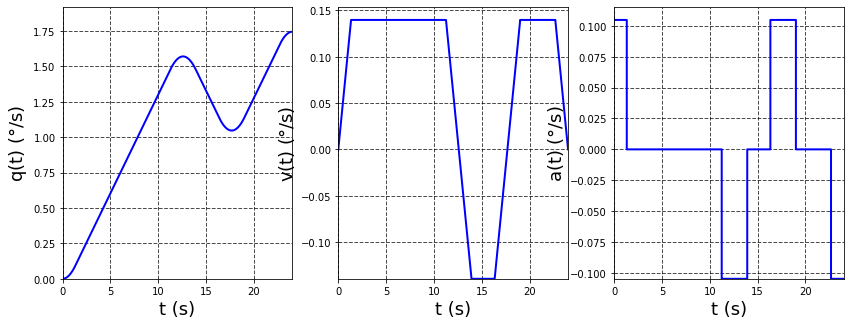

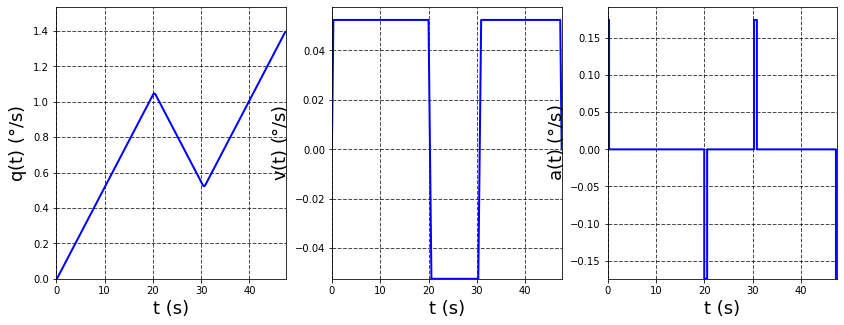

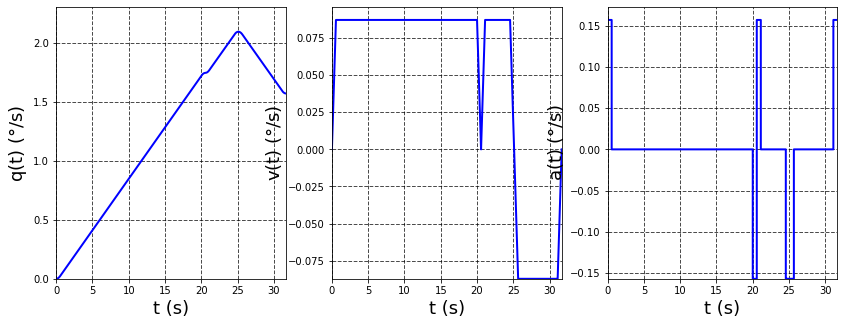

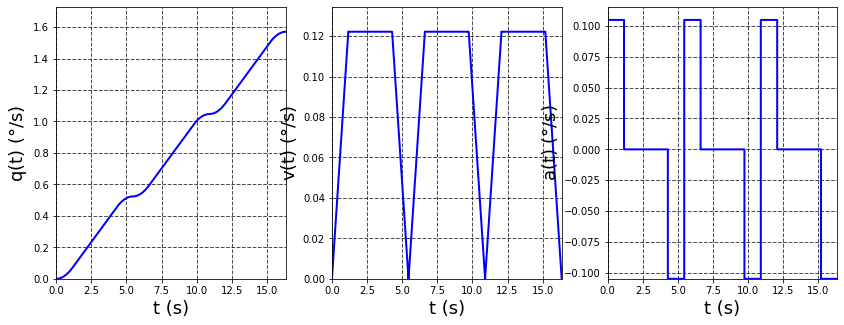

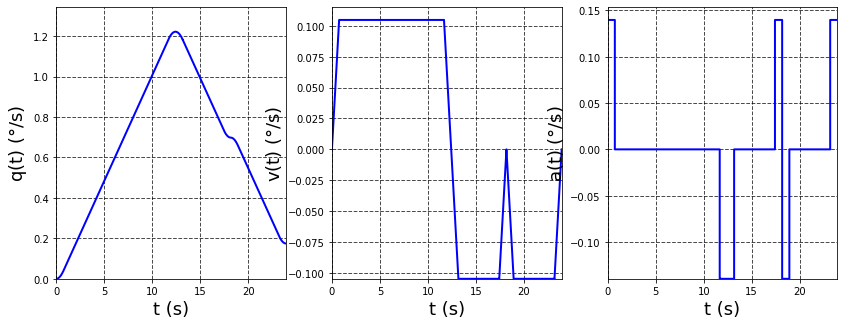

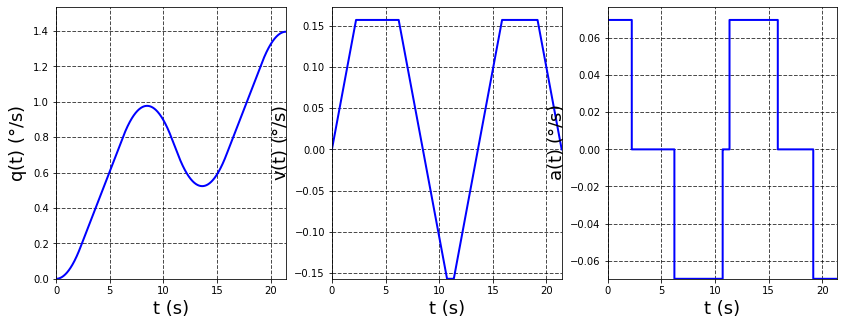

In [15]:
for joint in joints:
    joint.plot_path_points()

### Plot torques

In [16]:
def plot_torque(T_q, T, Q, V, A):
    torques = []
    
    for i in range(len(T[0])):
        params = {}
        for j in range(len(Q)):
            params[q[j]] = Q[j][i]
            params[dq[j]] = V[j][i]
            params[ddq[j]] = A[j][i]
        
        T_res = T_q.evalf(subs=params)
        torques.append(np.array(T_res)[:, 0])
    
    torques = np.array(torques)

    for i in range(len(Q)):
        plt.figure(figsize=(8, 6))
        plt.plot(T[i], torques[:, i])
        plt.show()

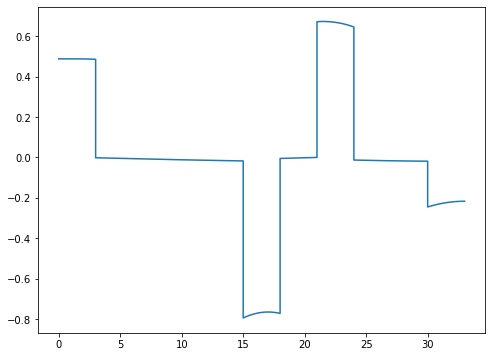

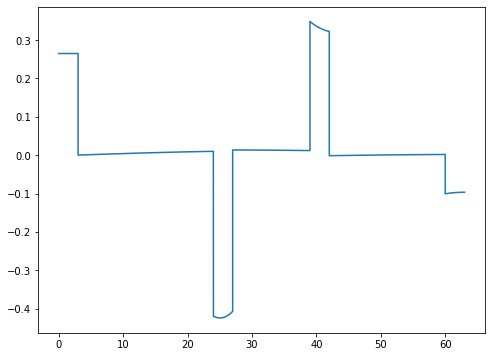

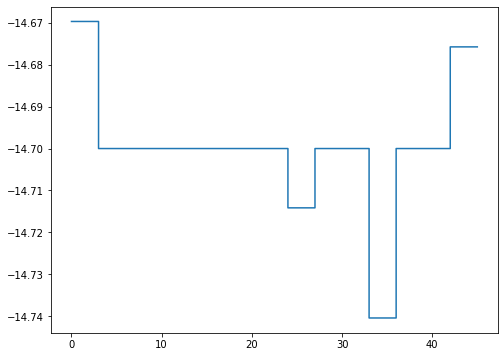

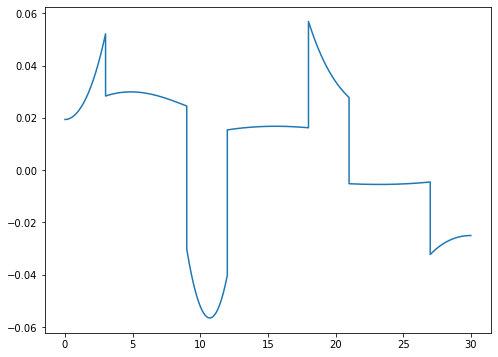

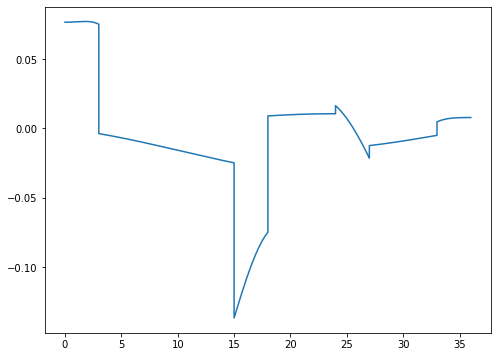

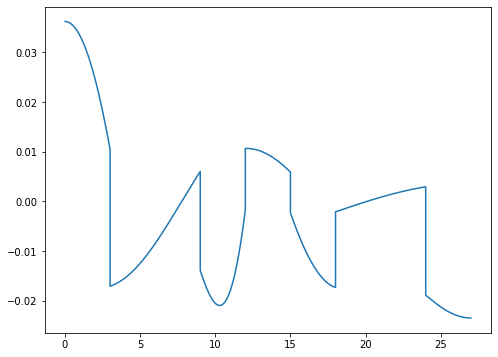

In [17]:
T, Q, V, A = [], [], [], []
for joint in joints:
    joint.trajectory_junction_ratio = 1
    joint.calculate_path()
    joint.numerical_control()

    t, q_, v, a = joint.get_path_points_for_plot()
    T.append(t)
    Q.append(q_)
    V.append(v)
    A.append(a)
    
plot_torque(T_q, T, Q, V, A)